In [3]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

def read_csv(folder_path, dataset_name, reduction_mode):
    if reduction_mode:
        csv_files = [f for f in os.listdir(folder_path) if (dataset_name in f and reduction_mode in f and 'all' not in f)]
    else:
        csv_files = [f for f in os.listdir(folder_path) if (dataset_name in f and 'all' not in f)]
    df_list = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df_list.append(df)

    df_combined = pd.concat(df_list, ignore_index=True)
    return df_combined

In [4]:
def aggregate_metrics(df_combined, method):
    if method == 'knn':
        columns = ['K', 'Distance', 'Voting scheme', 'Weight scheme']
    elif method == 'svm':
        columns = ['Kernel']
    
    grouped_df = df_combined.groupby(columns)

    # Compute mean and standard deviation of the relevant metrics
    metrics_summary = grouped_df.agg({
        'Accuracy': ['mean', 'std'],
        'Precision_Class_0': ['mean', 'std'],
        'Recall_Class_0': ['mean', 'std'],
        'F1_Class_0': ['mean', 'std'],
        'Precision_Class_1': ['mean', 'std'],
        'Recall_Class_1': ['mean', 'std'],
        'F1_Class_1': ['mean', 'std'],
        'Solving Time': ['mean', 'std']
    }).reset_index()


    # Rename the columns for clarity
    metrics_summary.columns = columns + [
                            'Accuracy_mean', 'Accuracy_std',
                            'Precision_Class_0_mean', 'Precision_Class_0_std',
                            'Recall_Class_0_mean', 'Recall_Class_0_std',
                            'F1_Class_0_mean', 'F1_Class_0_std',
                            'Precision_Class_1_mean', 'Precision_Class_1_std',
                            'Recall_Class_1_mean', 'Recall_Class_1_std',
                            'F1_Class_1_mean', 'F1_Class_1_std',
                            'Solving Time_mean', 'Solving Time_std']

    metrics_summary = metrics_summary.sort_values(by='Accuracy_mean', ascending = False)

    # Get the best hyperparameters (the first row after sorting)
    best_hyperparams = metrics_summary.iloc[0][columns].to_dict()
    best_accuracy = metrics_summary.iloc[0]['Accuracy_mean']

    # Print the best hyperparameters and their accuracy
    print("Best Hyperparameters:")
    print(best_hyperparams)
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    return metrics_summary, best_hyperparams


In [5]:
def get_metrics_knn(best_models, df_combined, metric):
    metric_values = []
    for _, row in best_models.iterrows():
        # Store model identification (e.g., hyperparameters)
        model_id = (row['Voting scheme'], row['Weight scheme'], row['Distance'], row['K'])

        # Filter for the current hyperparameter combination
        filtered_df = df_combined[
            (df_combined['Voting scheme'] == row['Voting scheme']) & 
            (df_combined['Weight scheme'] == row['Weight scheme']) &
            (df_combined['Distance'] == row['Distance']) &
            (df_combined['K'] == row['K'])
        ]
        # Collect accuracy values for this combination
        metric_values.append(list(filtered_df[metric].values))
    
    return metric_values

def get_metrics_svm(best_models, df_combined, metric):
    metric_values = []
    for _, row in best_models.iterrows():
        # Store model identification (e.g., hyperparameters)
        model_id = (row['Kernel'])

        # Filter for the current hyperparameter combination
        filtered_df = df_combined[
            (df_combined['Kernel'] == row['Kernel'])
        ]
    # Collect accuracy values for this combination
        metric_values.append(list(filtered_df[metric].values))
    
    return metric_values

In [33]:
from autorank import autorank, plot_stats, create_report

def plot_violin(data, metric, ax):
    """Helper function to plot the violin and strip plot."""
    sns.violinplot(data=data, ax=ax, inner=None, palette="pastel", linewidth=1.5)
    sns.stripplot(data=data, ax=ax, color='black', alpha=0.7, jitter=True, size=3)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f"Model {metric} Values", fontsize=16, fontweight='bold')
    ax.set_ylabel(metric, fontsize=14)
    ax.set_xlabel("Models", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

def plot_test(data, metric, results=None, autorank=False):
    if autorank:
        # Create a figure with two subplots for autorank and violin plot
        fig, axs = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [2, 5]})
        
        # Plot autorank results in the first subplot
        plot_stats(results, ax=axs[0])
        axs[0].set_title("Autorank Results")
        
        # Plot the violin in the second subplot
        plot_violin(data, metric, axs[1])
        
    else:
        # Create a single figure for the violin plot if autorank is False
        fig, ax = plt.subplots(figsize=(5, 4))
        plot_violin(data, metric, ax)
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

def evaluation_test_autorank(data, metric, p_value=0.05):
    results = autorank(data, alpha = p_value, order = 'descending')
    try:
        create_report(results)
    except:
        pass

    plot_test(data, metric, results=results, autorank=True)

            
def evaluation_test(data, metric, p_value=0.05):

    metric_values = [list(model) for model in data.T.values]

    # Perform the Friedman test if there are three or more models
    if len(metric_values) >= 3:
        stat, p_value_friedman = stats.friedmanchisquare(*metric_values)
        print(f"Friedman test statistic: {stat}, p-value: {p_value_friedman}")

        if p_value_friedman < p_value:
            print("Significant differences found, conducting Nemenyi post-hoc test")
            data = pd.DataFrame(metric_values).T  # Transpose so each column is a model
            nemenyi_result = sp.posthoc_nemenyi_friedman(data)
            print(nemenyi_result)
        else:
            print("No significant differences found between the models.")

    elif len(metric_values) == 2:
        stat, p_value = stats.wilcoxon(metric_values[0], metric_values[1])
        print(f"Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}")

        if p_value < 0.05:
            print("Significant difference between the two models.")
        else:
            print("No significant differences found between the two models.")

    else:
        print("Not enough data to perform the test.")
        return
    plot_test(data, metric, results=None, autorank=False)


In [14]:
def evaluation_t_test(metric_values1, metric_values2):

    stat, p_value = stats.ttest_rel(metric_values1, metric_values2)
    print(f"Paired t-test statistic: {stat}, p-value: {p_value}")

    if p_value < 0.05:
        print("Significant difference found between the two models.")
    else:
        print("No significant differences found between the two models.")

Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9672
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population Mj_MC_m2_7 (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is gre

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


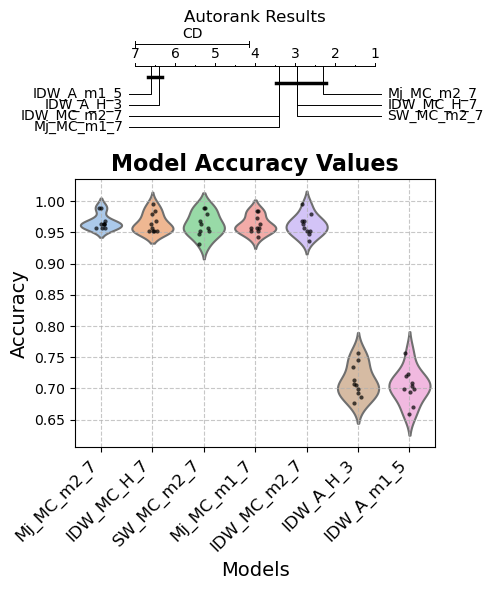

In [41]:
dataset_name = 'grid'
method = 'knn'
metric = 'Accuracy'

def evaluate_models(dataset_name, method, metric, type_evaluation= 'our_criteria'):

    votings = {'Majority_class': 'Mj', 'Inverse_Distance_Weights': 'IDW','Sheppards_Work': 'SW'}
    distances = {'minkowski1': 'm1', 'minkowski2': 'm2', 'HEOM': 'H',    }
    weighting = {'Mutual_classifier':'MC', 'Relief': 'R', 'ANOVA': 'A'}

    df_combined = read_csv(f'results_{method}', dataset_name, False)
    metrics_summary, best_hyperparams = aggregate_metrics(df_combined, method)
    metrics_summary.to_csv(f'results_{method}/results_{dataset_name}_all.csv', index=False)

    if method == 'knn':
        best_models = metrics_summary.iloc[[0, 1, 2, 3, 4, 90, 100]]
        metric_values = get_metrics_knn(best_models, df_combined, metric)
        data = pd.DataFrame()
        for el, (i,row) in zip(metric_values, best_models.iterrows()):
            data[f"{votings[row['Voting scheme']]}_{weighting[row['Weight scheme']]}_{distances[row['Distance']]}_{row['K']}"] = el

    elif method == 'svm':
        best_models = metrics_summary.iloc[[0, 1]]
        metric_values = get_metrics_svm(best_models, df_combined ,metric)
        data = pd.DataFrame()
        for el, (i,row) in zip(metric_values, best_models.iterrows()):
            data[f"{row['Kernel']}"] = el
            
    if type_evaluation == 'autorank':
        evaluation_test_autorank(data, metric, 0.05)
    elif type_evaluation == 'our_criteria':
        evaluation_test(data, metric, 0.05)
    
evaluate_models(dataset_name, method, metric, type_evaluation= 'autorank')

Evaluating method knn on dataset: grid
Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9672
Evaluating Accuracy
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population Mj_MC_m2_7 (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


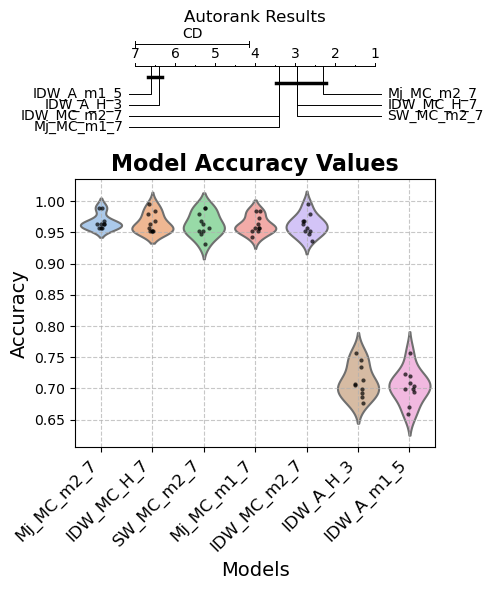

Evaluating Solving Time
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population IDW_A_H_3 (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.848 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that t

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


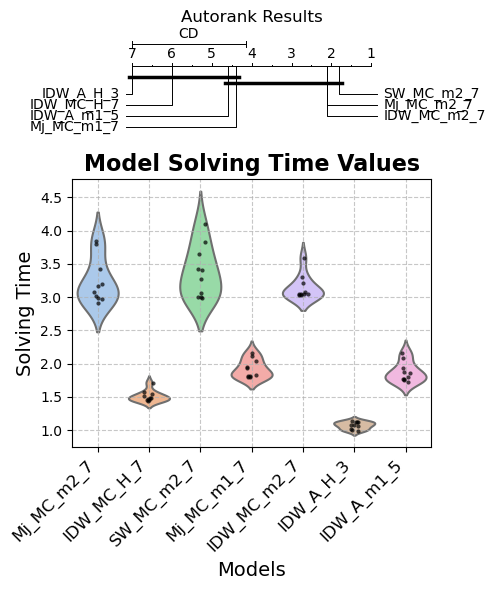



Evaluating method svm on dataset: grid
Best Hyperparameters:
{'Kernel': 'rbf'}
Best Accuracy: 0.9142
Evaluating Accuracy
The statistical analysis was conducted for 2 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.095). Therefore, we assume that all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both populations are normal, we use the t-test to determine differences between the mean values of the populations and report the mean value (M)and the standard deviation (SD) for each population. 
We reject the null hypothesis (p=0.000) of the paired t-test that the mean values of the populations sigmoid (M=0.155+-0.025, SD=0.029) and rbf (M=0.914+-0.013, SD=0.016) are equal. Therefore, we assume that the mean value of rbf is signif

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


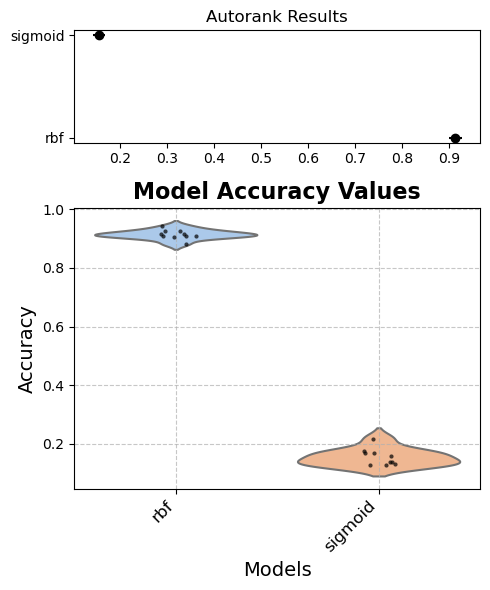

Evaluating Solving Time
The statistical analysis was conducted for 2 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population sigmoid (p=0.000). Therefore, we assume that not all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and one of them is not normal, we use Wilcoxon's signed rank test to determine the differences in the central tendency and report the median (MD) and the median absolute deviation (MAD) for each population.
We reject the null hypothesis (p=0.001) of Wilcoxon's signed rank test that population sigmoid (MD=0.648+-0.028, MAD=0.004) is not greater than population rbf (MD=0.287+-0.009, MAD=0.005). Therefore, we assume that the median of sigmoid is significantly larger than the median value of rbf with a large effect size (gamma=-53.757).


c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\autorank\autorank.py:364: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')
C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


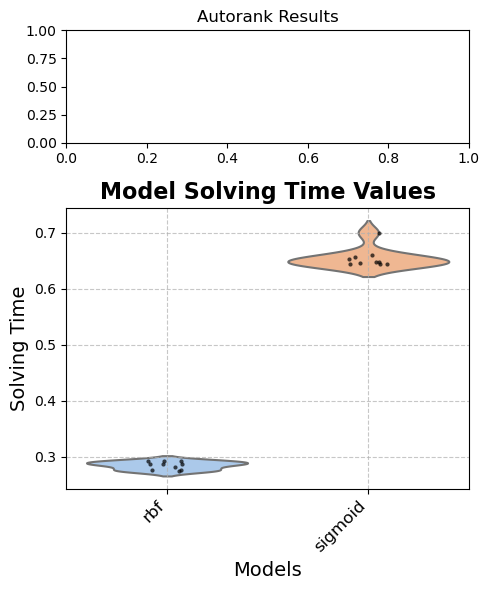



Evaluating method knn on dataset: sick
Best Hyperparameters:
{'K': 7, 'Distance': 'HEOM', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9626
Evaluating Accuracy
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.433). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=1.000) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use th

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


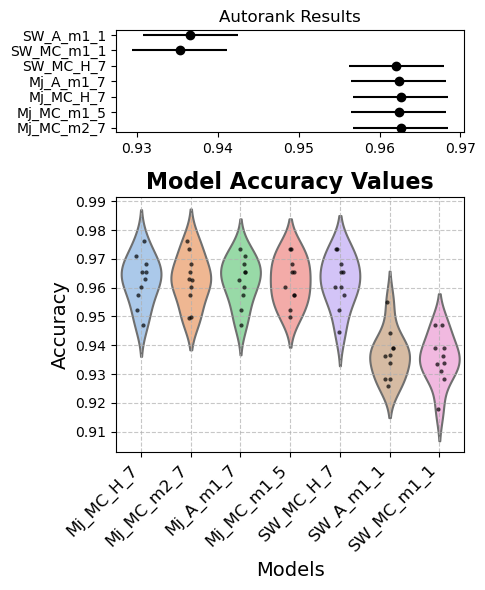

Evaluating Solving Time
The statistical analysis was conducted for 7 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations Mj_MC_m1_5 (p=0.001) and Mj_MC_m2_7 (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.848 of the Nemenyi test.
We reject the null hypothesis (p=0.000

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


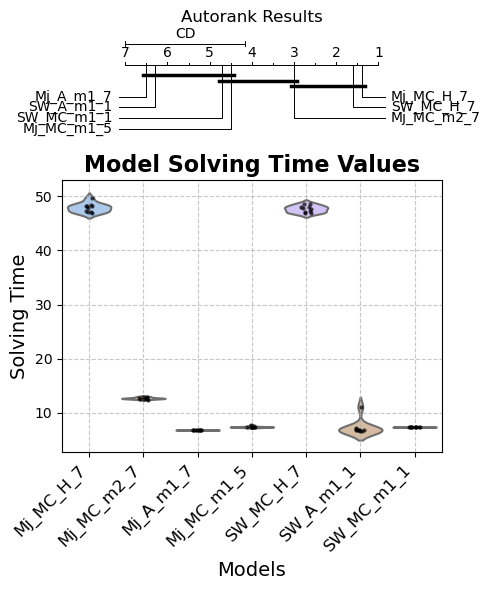



Evaluating method svm on dataset: sick
Best Hyperparameters:
{'Kernel': 'rbf'}
Best Accuracy: 0.9594
Evaluating Accuracy
The statistical analysis was conducted for 2 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.859). Therefore, we assume that all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both populations are normal, we use the t-test to determine differences between the mean values of the populations and report the mean value (M)and the standard deviation (SD) for each population. 
We reject the null hypothesis (p=0.018) of the paired t-test that the mean values of the populations sigmoid (M=0.956+-0.009, SD=0.010) and rbf (M=0.959+-0.009, SD=0.010) are equal. Therefore, we assume that the mean value of rbf is signif

C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


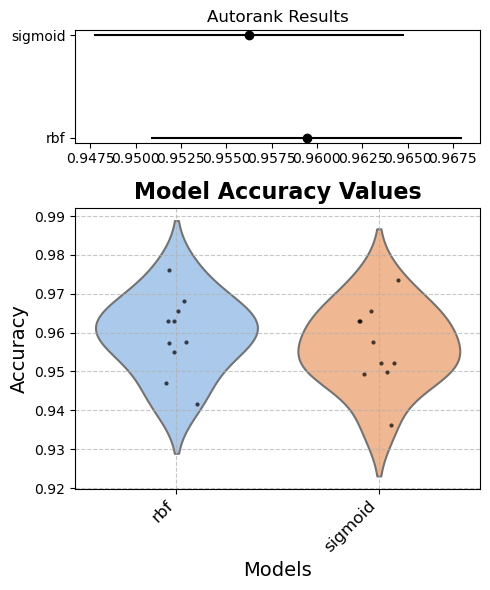

Evaluating Solving Time
The statistical analysis was conducted for 2 populations with 10 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population sigmoid (p=0.002). Therefore, we assume that not all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and one of them is not normal, we use Wilcoxon's signed rank test to determine the differences in the central tendency and report the median (MD) and the median absolute deviation (MAD) for each population.
We reject the null hypothesis (p=0.001) of Wilcoxon's signed rank test that population rbf (MD=0.552+-0.039, MAD=0.017) is not greater than population sigmoid (MD=0.277+-0.052, MAD=0.013). Therefore, we assume that the median of rbf is significantly larger than the median value of sigmoid with a large effect size (gamma=-12.197).


c:\Users\xavid\anaconda3\envs\ML\lib\site-packages\autorank\autorank.py:364: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')
C:\Users\xavid\AppData\Local\Temp\ipykernel_19748\2929316064.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


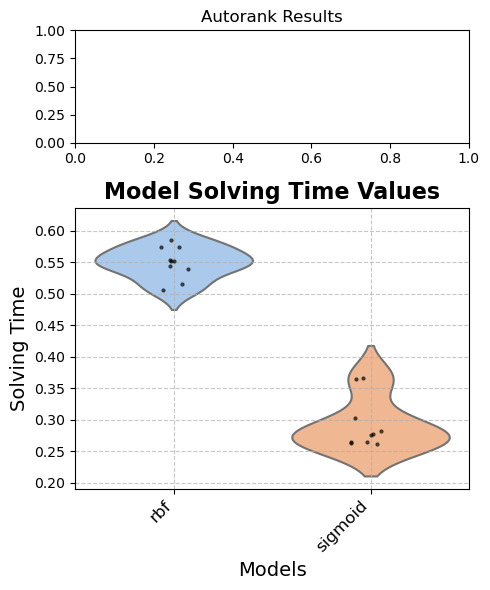

In [ ]:
#Read_csvs

dataset_names = ['grid','sick']
methods = ['knn','svm']
best_params = {}


for dataset_name in dataset_names:
    best_params[dataset_name] = {}
    for method in methods:
        print(f'Evaluating method {method} on dataset: {dataset_name}')
        df_combined = read_csv(f'results_{method}', dataset_name, False)
        metrics_summary, best_hyperparams = aggregate_metrics(df_combined, method)
        metrics_summary.to_csv(f'results_{method}/results_{dataset_name}_all.csv', index=False)
        best_params[dataset_name][method] = best_hyperparams

        for metric in ['Accuracy', 'Solving Time']:
            print(f'Evaluating {metric}')


            if method == 'knn':
                best_models = metrics_summary.iloc[[0, 1, 2, 3, 4, 90, 100]]
                metric_values = get_metrics_knn(best_models, df_combined, metric)
                data = pd.DataFrame()
                for el, (i,row) in zip(metric_values, best_models.iterrows()):
                    data[f"{votings[row['Voting scheme']]}_{weighting[row['Weight scheme']]}_{distances[row['Distance']]}_{row['K']}"] = el

            elif method == 'svm':
                best_models = metrics_summary.iloc[[0, 1]]
                metric_values = get_metrics_svm(best_models, df_combined ,metric)
                data = pd.DataFrame()
                for el, (i,row) in zip(metric_values, best_models.iterrows()):
                    data[f"{row['Kernel']}"] = el
            
            
            evaluation_test_autorank(data, metric, 0.05)
            
        print('\n')

 

In [37]:
dataframe_best_results_together = {}

num_samples = {'grid': 1700, 'sick': 3395}

for dataset_name in dataset_names:
    dataframe_best_results_together[dataset_name] = pd.DataFrame()
    for method in methods:
        df_combined = read_csv(f'results_{method}', dataset_name, False)
        metrics_summary, best_hyperparams = aggregate_metrics(df_combined, method)

        metric = 'Accuracy'
        
        # Make a copy of the best_models DataFrame to avoid SettingWithCopyWarning
        best_models = metrics_summary.head(5).copy()
        
        if method == 'knn':
            metric_values = get_metrics_knn(best_models, df_combined, metric)[0]
        elif method == 'svm':
            metric_values = get_metrics_svm(best_models, df_combined, metric)[0]
        
        best_models.loc[:, 'Method'] = method
        best_models.loc[:, 'Num samples'] = num_samples[dataset_name]
        dataframe_best_results_together[dataset_name] = pd.concat((dataframe_best_results_together[dataset_name], best_models.head(1)))

        for reduction in ['CNN', 'DROP', 'EENTh']:

            print(f'\nComparing method {method} on dataset {dataset_name} with reduction {reduction}')
            results_reduced = read_csv(f'results_{method}_reduced', dataset_name, reduction)
            metrics_summary, best_hyperparams = aggregate_metrics(results_reduced, method)
            
            # Make a copy of the best_models DataFrame to avoid SettingWithCopyWarning
            best_models = metrics_summary.head(5).copy()
            
            best_models.loc[:, 'Method'] = method
            best_models.loc[:, 'reduction'] = reduction
            best_models.loc[:, 'Num samples'] = results_reduced['Num samples']
            
            dataframe_best_results_together[dataset_name] = pd.concat((dataframe_best_results_together[dataset_name], best_models.head(1)))
            
            metrics_summary.to_csv(f'results_{method}_reduced/results_{dataset_name}_{reduction}_all.csv', index=False)
            metric_values_reduced = results_reduced['Accuracy'].values
            
            evaluation_t_test(metric_values, metric_values_reduced)

Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.9672

Comparing method knn on dataset grid with reduction CNN
Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.6748
Paired t-test statistic: 9.179625086610036, p-value: 7.261484712335037e-06
Significant difference found between the two models.

Comparing method knn on dataset grid with reduction DROP
Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutual_classifier'}
Best Accuracy: 0.8000
Paired t-test statistic: 4.597706657399072, p-value: 0.001294742955656102
Significant difference found between the two models.

Comparing method knn on dataset grid with reduction EENTh
Best Hyperparameters:
{'K': 7, 'Distance': 'minkowski2', 'Voting scheme': 'Majority_class', 'Weight scheme': 'Mutua

In [38]:
columns = ['Accuracy_mean', 'Num samples', 'Solving Time_mean', 'reduction', 'Method'] 
dataframe_best_results_together['grid'][columns]

,Accuracy_mean,Num samples,Solving Time_mean,reduction,Method
103,0.967162,1700,3.240735,NaN,knn
0,0.674809,222,0.690698,CNN,knn
0,0.800018,247,0.720960,DROP,knn
0,0.968206,1533,4.586887,EENTh,knn
0,0.914167,1700,0.284618,NaN,svm
0,0.865512,222,0.035796,CNN,svm
0,0.879728,247,0.045527,DROP,svm
0,0.914167,1533,0.289909,EENTh,svm


- is it necessary to do a nemenyi if when doing the friedman pvalue is higher tan 0.05?
Lower the alpha to get more significant differences or include a bad and intermediate solution.

- can we use a library for the tests?
Yes.

- result plots?
No hay preferencia, segun hilo argumental.
Depende de como explicamos los resultados.

- metodologia profundament o no
Nada excepto particular.

- anova f-value com a weighting?


In [ ]:


-